# PCA Coefficient MMSFM Analysis

This notebook inspects PCA-based MMSFM runs produced by `pca_main.py` and `modelagent.py`. Update `RESULT_DIR` below to the run you want to study; all derived artefacts will be written to `notebook_artifacts/` inside that directory.


In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import torch
from IPython.display import Image, display

PROJECT_ROOT = Path.cwd().parent.resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from scripts.pca.pca_visualization_utils import (
    load_pca_run_artifacts,
    list_trajectory_epochs,
    load_trajectory_array,
    plot_coefficient_scatter,
    plot_coefficient_trajectories,
    TimeConditionedFlow,
)
from scripts.images.field_visualization import (
    reconstruct_fields_from_coefficients,
    plot_field_snapshots,
    plot_field_evolution_gif,
    plot_field_statistics,
    plot_sample_comparison_grid,
    plot_spatial_correlation,
    plot_eigenvalue_spectra_comparison,
    plot_covariance_heatmaps_comparison,
    plot_vector_field_2d_projection,
    plot_vector_field_streamplot,
    plot_interpolated_probability_paths,
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_DIR = PROJECT_ROOT
RESULT_DIR = BASE_DIR / "results" / "2025-10-28T15-59-01-98"
ARTIFACT_DIR = RESULT_DIR / "notebook_artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

def show_artifact(name: str) -> None:
    path = ARTIFACT_DIR / name
    if path.exists():
        display(Image(filename=str(path)))
    else:
        print(f"Missing artifact: {path}")

print(f"Using device: {DEVICE}")
print(f"Results directory: {RESULT_DIR}")
print(f"Artifacts saved to: {ARTIFACT_DIR}")


/home/jy384/miniconda3/envs/3MASB/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/jy384/miniconda3/envs/3MASB/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened becau

Using device: cuda
Results directory: /data1/jy384/research/MMSFM/results/2025-10-28T15-59-01-98
Artifacts saved to: /data1/jy384/research/MMSFM/results/2025-10-28T15-59-01-98/notebook_artifacts


## Load Configuration and Models

Parse the stored training arguments, rebuild the PCA flow models, and prepare convenience tensors for later analysis.


In [2]:
run_ctx = load_pca_run_artifacts(RESULT_DIR, base_dir=BASE_DIR, device=DEVICE)
config = run_ctx.config
zt_values = run_ctx.zt

progression_coeffs = run_ctx.test_marginals(normalized=False)
progression_coeffs_norm = run_ctx.test_marginals(normalized=True, device=DEVICE)

run_ctx.flow_model.eval()
if run_ctx.score_model is not None:
    run_ctx.score_model.eval()

print(f"Model: {config.get('modelname')} (depth={config.get('modeldepth')}, width={config.get('w_len')})")
print(f"Flow matcher: {config.get('flowmatcher')} | Agent type: {config.get('agent_type')}")
print(f"Scaler: {run_ctx.scaler_type} | Sigma: {run_ctx.sigma}")
print(f"Coefficient dimensionality: {run_ctx.coeff_dim}")
if run_ctx.resolution is not None:
    print(f"Reconstructed field resolution: {run_ctx.resolution} x {run_ctx.resolution}")
else:
    print("Reconstructed field resolution: unavailable (non-square data_dim)")
print(f"n_infer={run_ctx.n_infer}, t_infer={run_ctx.t_infer}")
print(f"zt: {zt_values}")

x0_norm, xT_norm = run_ctx.endpoints(normalized=True, device=DEVICE)
flow_wrapper = run_ctx.flow_wrapper().to(DEVICE)
flow_wrapper.eval()


Model: resnet (depth=8, width=256)
Flow matcher: sb | Agent type: triplet
Scaler: standard | Sigma: 0.3
Coefficient dimensionality: 264
Reconstructed field resolution: 32 x 32
n_infer=200, t_infer=400
zt: [0.   0.25 0.5  0.75 1.  ]


TimeConditionedFlow(
  (base_model): ResNet(
    (input_layer): Linear(in_features=265, out_features=256, bias=True)
    (input_act): SELU()
    (blocks): ModuleList(
      (0-7): 8 x ResidualBlock(
        (fc1): Linear(in_features=256, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=256, bias=True)
        (act): SELU()
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
    (output_layer): Linear(in_features=256, out_features=264, bias=True)
  )
)

## Load Stored Trajectories

Most diagnostics focus on the last saved epoch. Adjust `target_epoch` if you want to inspect earlier checkpoints.


In [3]:
ode_epochs = list_trajectory_epochs(RESULT_DIR, "ode")
if not ode_epochs:
    raise FileNotFoundError("No ODE trajectories found in the selected run.")
target_epoch = ode_epochs[-1]

ode_traj = load_trajectory_array(RESULT_DIR, "ode", epoch=target_epoch)
torch_ode = torch.from_numpy(ode_traj).float()

print(f"Loaded ODE trajectory from epoch {target_epoch}: shape={torch_ode.shape}")

if run_ctx.is_sb:
    sde_epochs = list_trajectory_epochs(RESULT_DIR, "sde")
    if sde_epochs:
        sde_epoch = sde_epochs[-1]
        sde_traj = load_trajectory_array(RESULT_DIR, "sde", epoch=sde_epoch)
        torch_sde = torch.from_numpy(sde_traj).float()
        print(f"Loaded SDE trajectory from epoch {sde_epoch}: shape={torch_sde.shape}")
    else:
        torch_sde = None
        print("Schrödinger Bridge run detected, but no SDE trajectories were saved.")
else:
    torch_sde = None


Loaded ODE trajectory from epoch 10: shape=torch.Size([400, 200, 264])
Loaded SDE trajectory from epoch 10: shape=torch.Size([400, 200, 264])


## Coefficient Marginal Snapshots


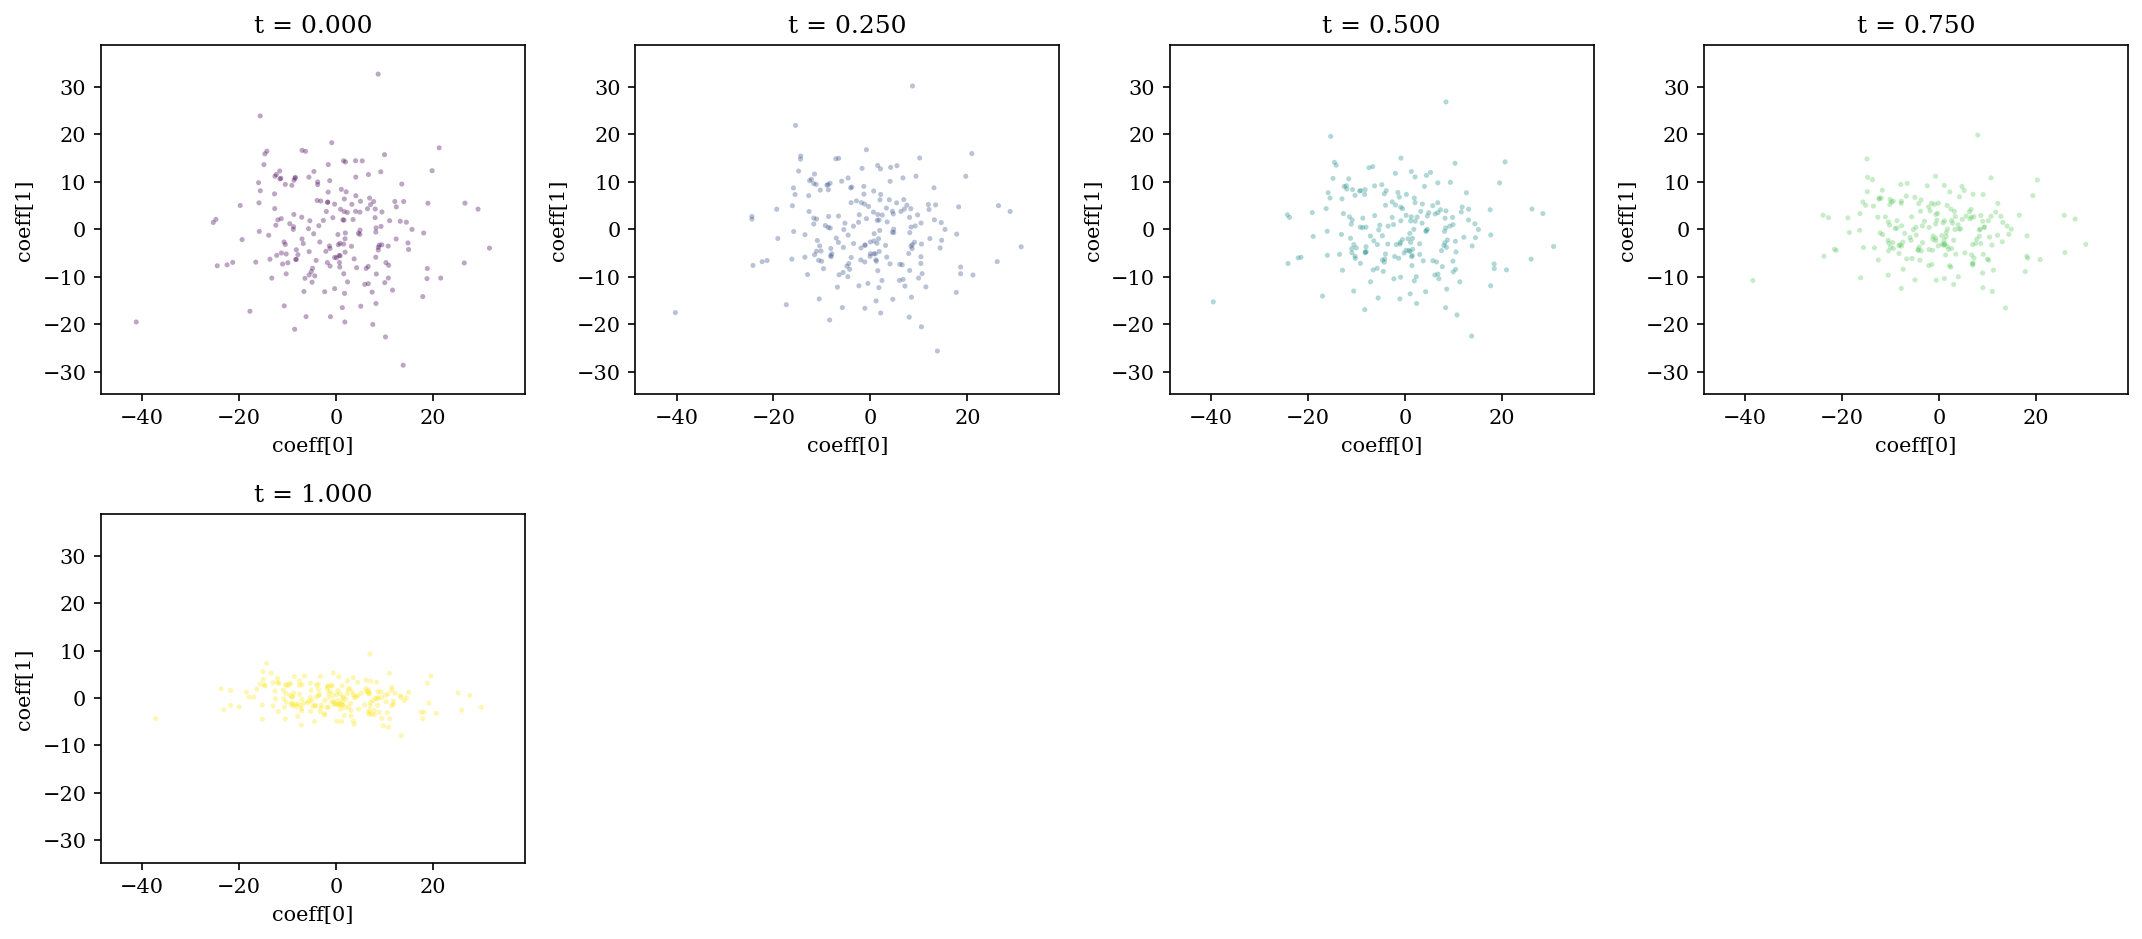

In [4]:
coeff_scatter_path = ARTIFACT_DIR / f"coeff_marginals_epoch{target_epoch}.png"
plot_coefficient_scatter(
    progression_coeffs,
    zt_values,
    out_path=coeff_scatter_path,
    close=True,
)
display(Image(filename=str(coeff_scatter_path)))


## Sample Trajectories in Coefficient Space


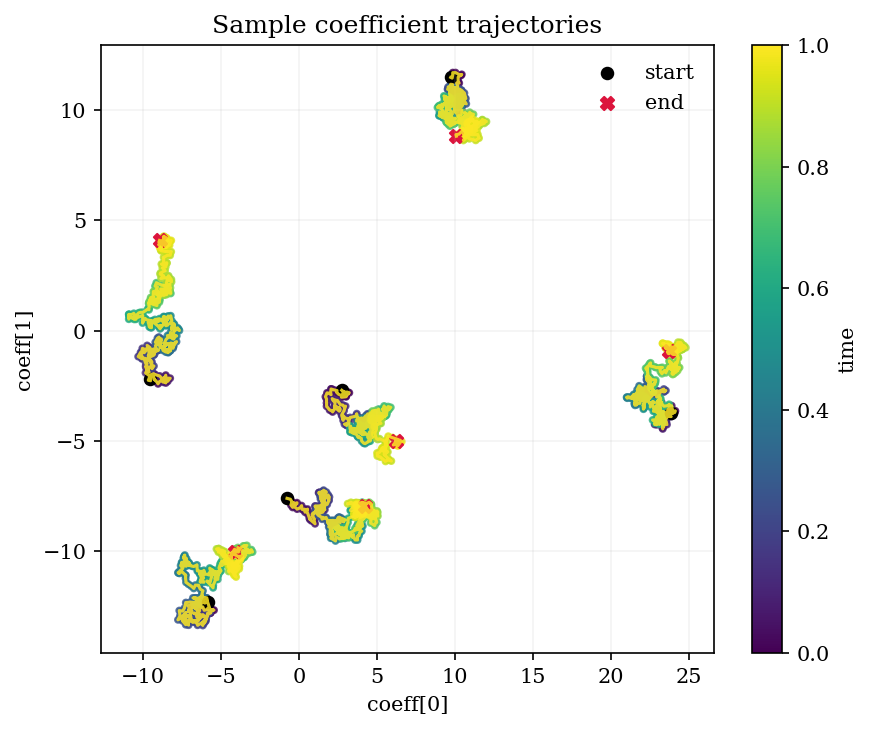

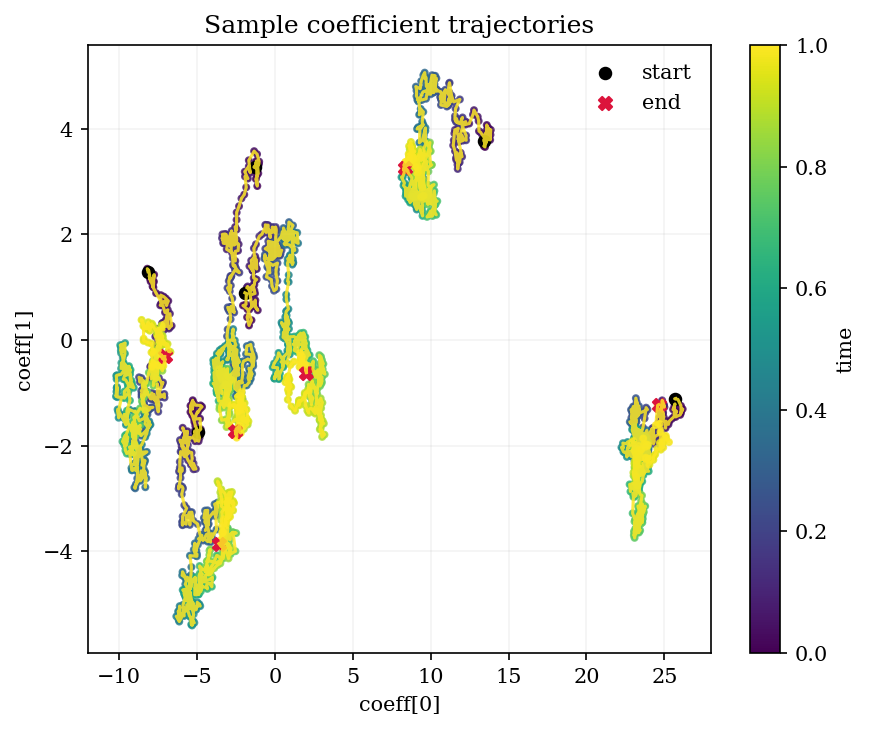

In [5]:
time_grid = np.linspace(0.0, 1.0, torch_ode.shape[0])
traj_plot_path = ARTIFACT_DIR / f"coeff_trajectories_ode_epoch{target_epoch}.png"
plot_coefficient_trajectories(
    torch_ode,
    time_points=time_grid,
    n_samples=6,
    out_path=traj_plot_path,
    close=True,
)
display(Image(filename=str(traj_plot_path)))

if torch_sde is not None:
    sde_traj_plot_path = ARTIFACT_DIR / f"coeff_trajectories_sde_epoch{sde_epoch}.png"
    plot_coefficient_trajectories(
        torch_sde,
        time_points=time_grid,
        n_samples=6,
        out_path=sde_traj_plot_path,
        close=True,
    )
    display(Image(filename=str(sde_traj_plot_path)))


## Field Reconstructions and Diagnostics


Generating ODE field diagnostics...


MovieWriter imagemagick unavailable; using Pillow instead.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


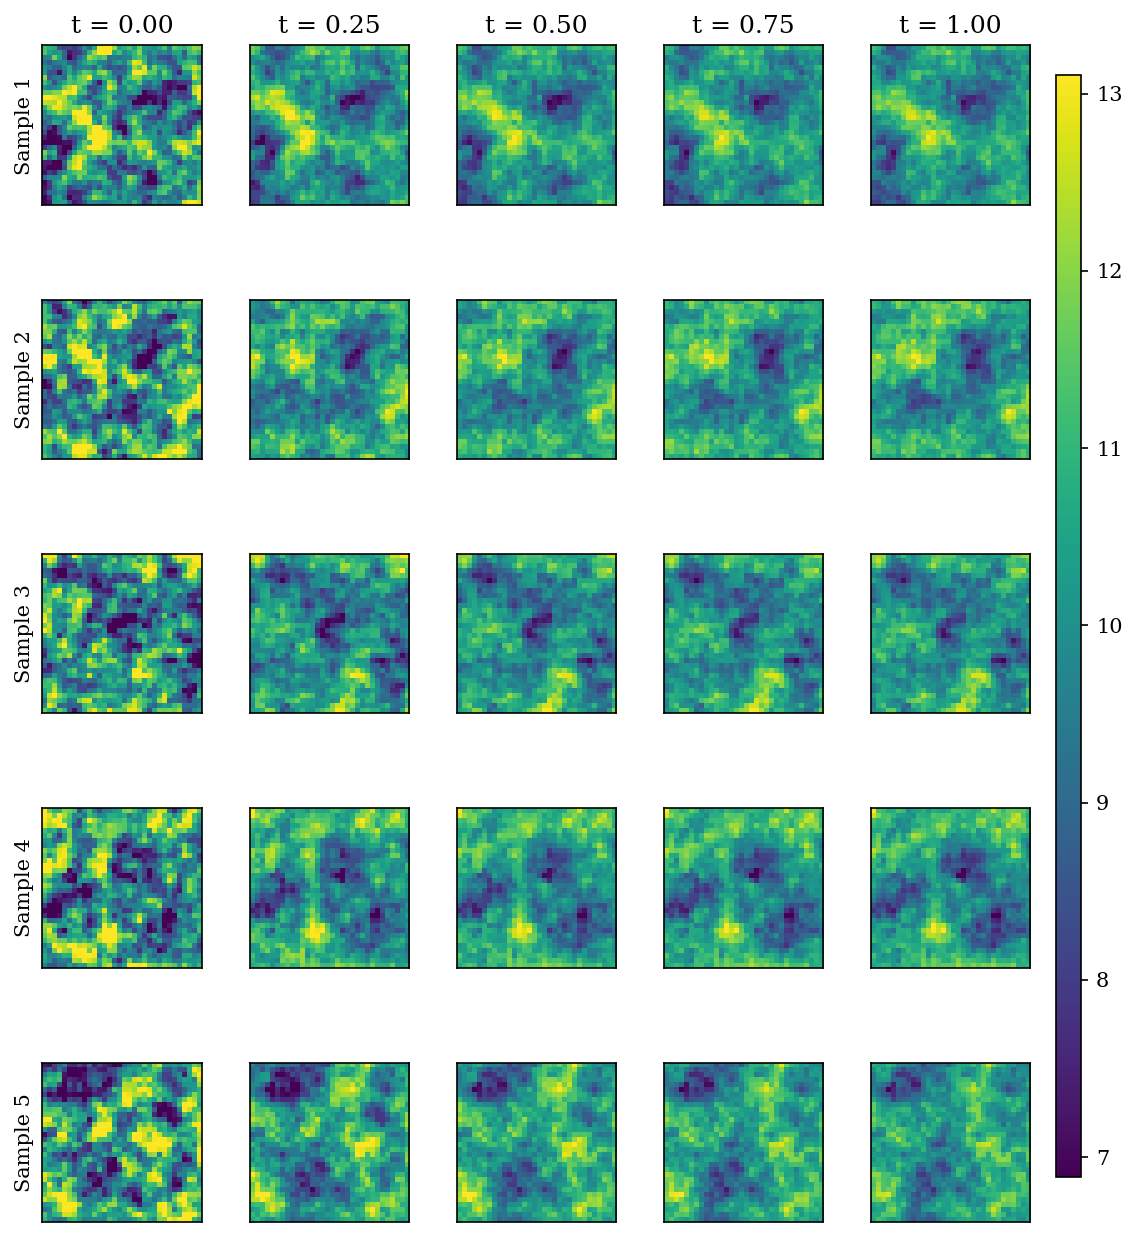

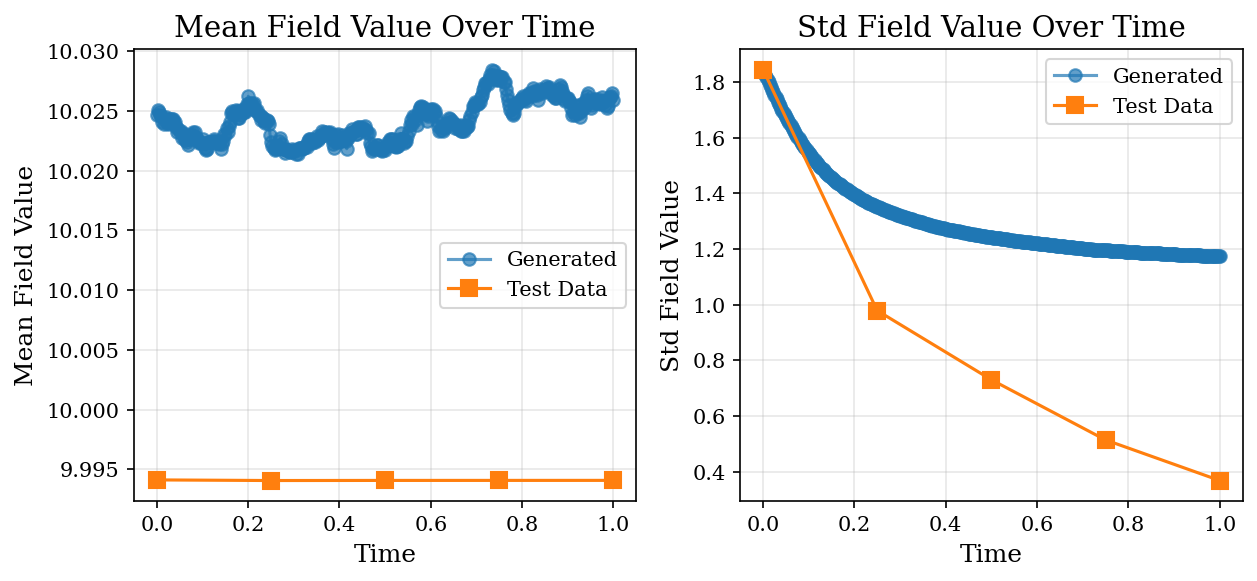

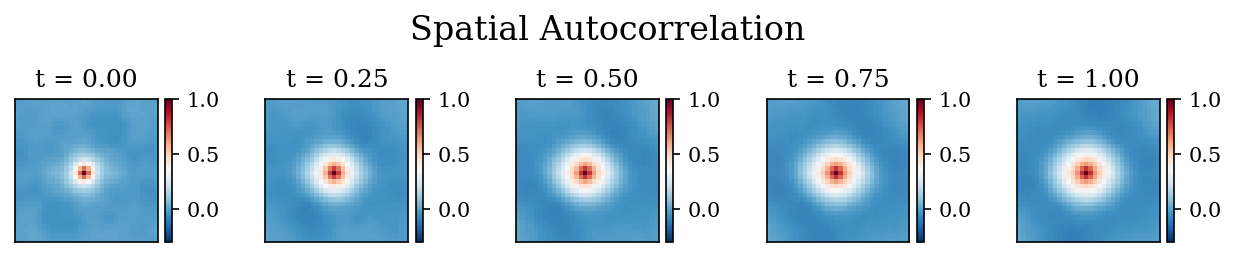

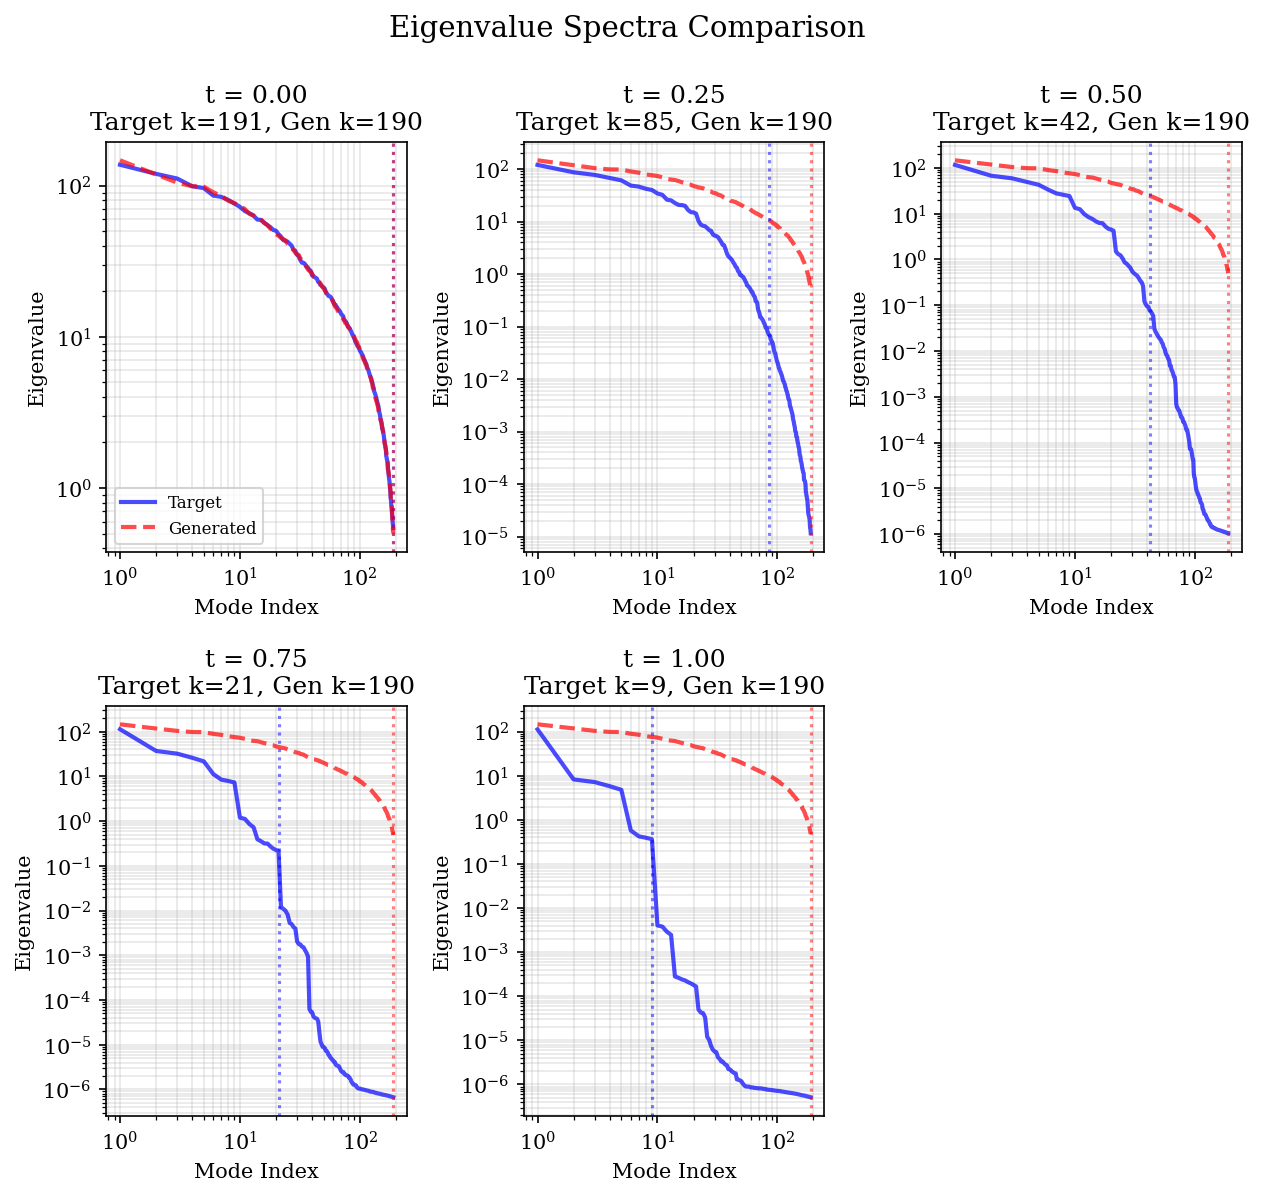

Generating SDE field diagnostics...


MovieWriter imagemagick unavailable; using Pillow instead.


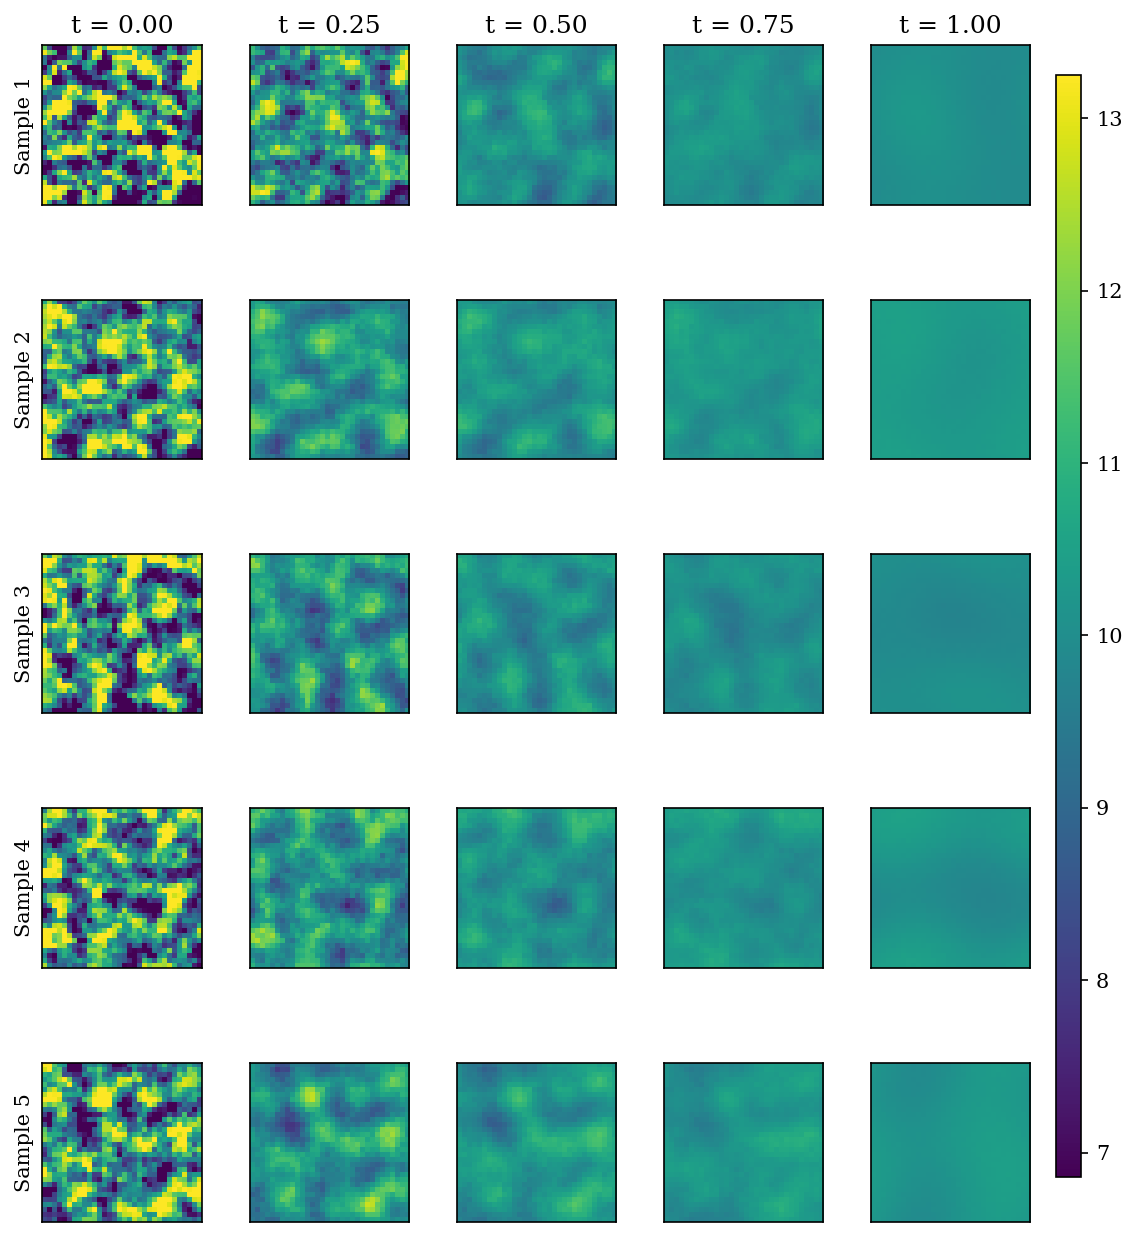

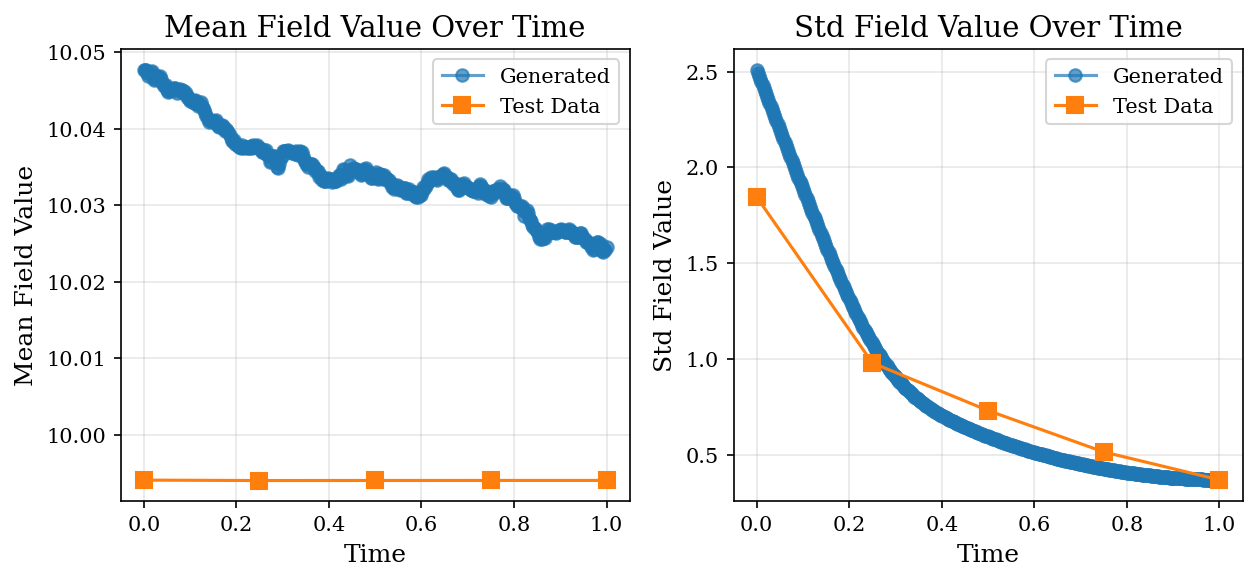

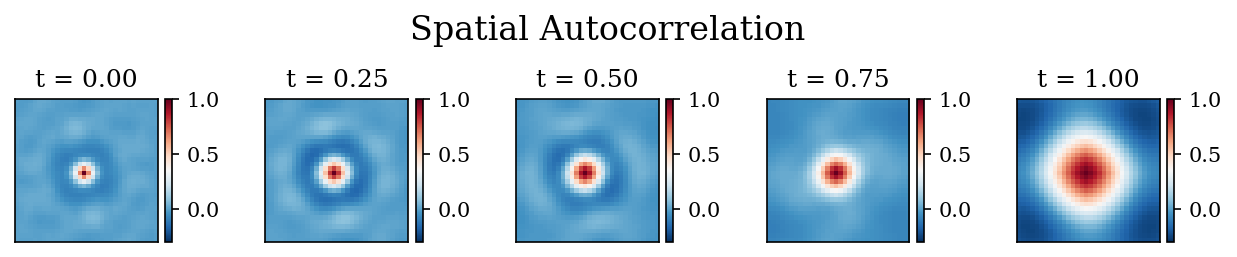

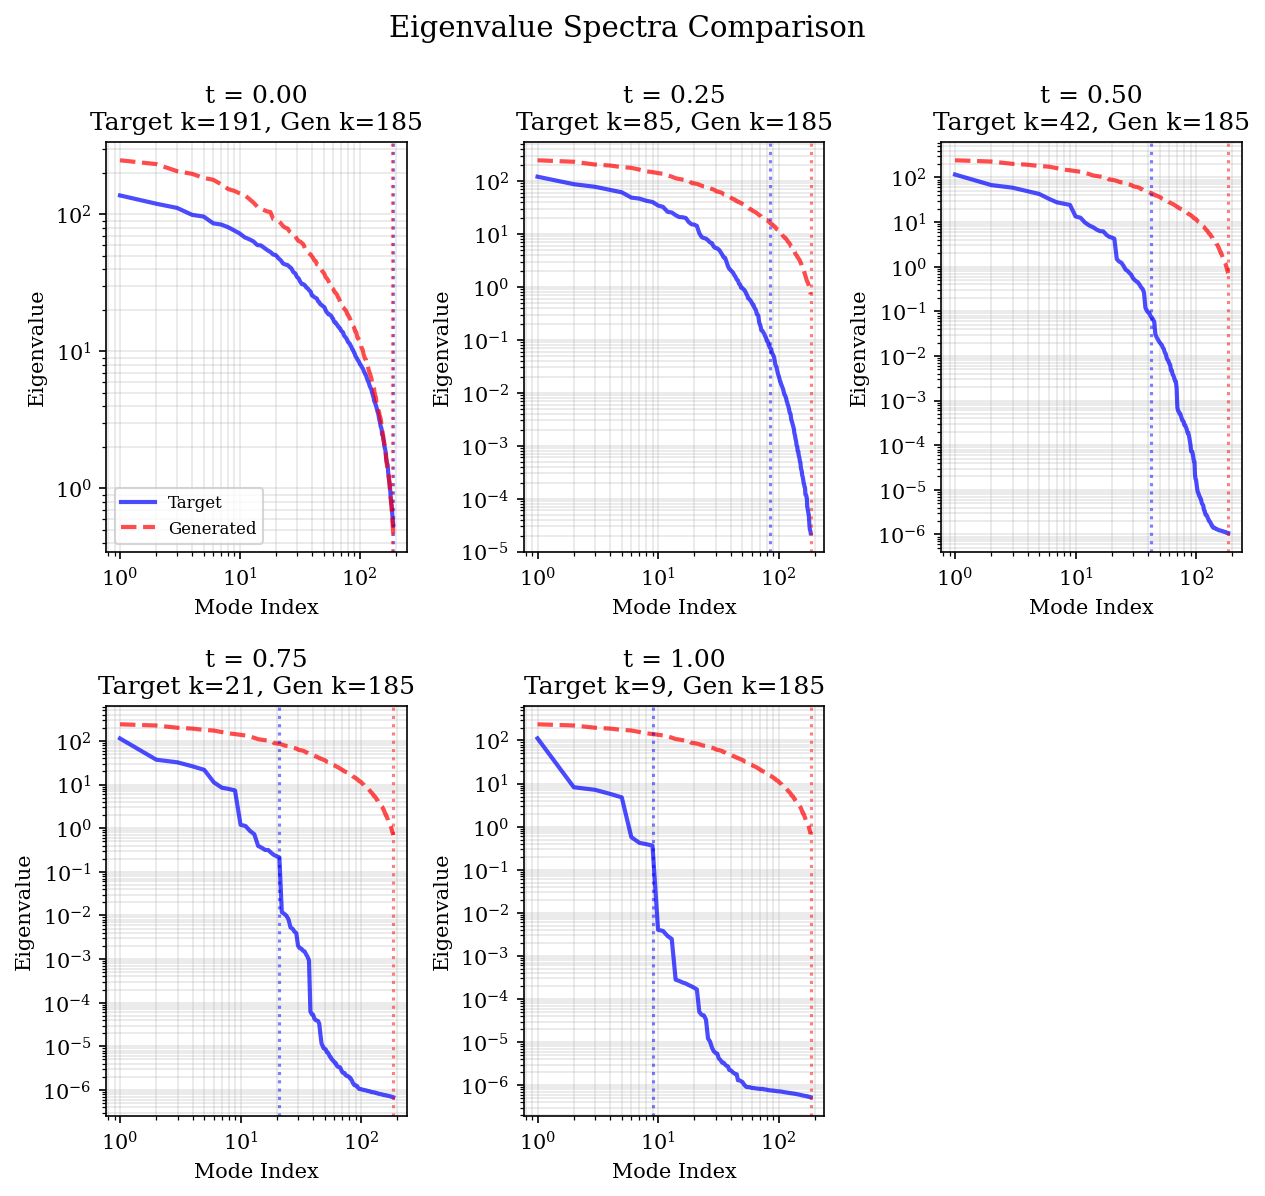

In [6]:
if run_ctx.resolution is None:
    print("Skipping field diagnostics because the dataset does not map to a square grid.")
else:
    resolution = run_ctx.resolution
    outdir = str(ARTIFACT_DIR)

    class NotebookRun:
        def log(self, data):
            return None

    notebook_run = NotebookRun()

    ode_fields = reconstruct_fields_from_coefficients(ode_traj, run_ctx.pca_info, resolution)
    target_coeff_stack = np.stack([tensor.numpy() for tensor in progression_coeffs], axis=0)
    target_fields = reconstruct_fields_from_coefficients(target_coeff_stack, run_ctx.pca_info, resolution)
    target_field_list = [target_fields[idx] for idx in range(target_fields.shape[0])]

    print("Generating ODE field diagnostics...")
    plot_field_snapshots(ode_fields, zt_values, outdir, notebook_run, n_samples=min(5, ode_fields.shape[1]), score=False)
    plot_field_evolution_gif(ode_fields, zt_values, outdir, notebook_run, sample_idx=0, score=False, fps=5)
    plot_field_statistics(ode_fields, zt_values, target_field_list, outdir, notebook_run, score=False)
    plot_sample_comparison_grid(target_field_list, ode_fields, zt_values, outdir, notebook_run, score=False, n_samples=5)
    plot_spatial_correlation(ode_fields, zt_values, outdir, notebook_run, score=False)

    import torch as _torch

    ode_cov_dict = {}
    target_cov_dict = {}
    for idx, t_val in enumerate(zt_values):
        flat_generated = ode_fields[idx].reshape(ode_fields.shape[1], -1)
        flat_target = target_field_list[idx].reshape(target_field_list[idx].shape[0], -1)
        ode_cov_dict[float(t_val)] = _torch.from_numpy(flat_generated).float()
        target_cov_dict[float(t_val)] = _torch.from_numpy(flat_target).float()

    select_indices = np.linspace(0, len(zt_values) - 1, min(5, len(zt_values))).astype(int)
    selected_times = [float(zt_values[i]) for i in select_indices]

    plot_eigenvalue_spectra_comparison(
        target_cov_dict,
        ode_cov_dict,
        selected_times,
        variance_threshold=0.999,
        outdir=outdir,
        run=notebook_run,
        score=False,
    )
    plot_covariance_heatmaps_comparison(
        target_cov_dict,
        ode_cov_dict,
        selected_times,
        max_dim_for_heatmap=32,
        variance_threshold=0.999,
        outdir=outdir,
        run=notebook_run,
        score=False,
    )

    show_artifact("field_snapshots_ode.png")
    show_artifact("field_statistics_ode.png")
    show_artifact("spatial_correlation_ode.png")
    show_artifact("covariance_diagnostics_ode_eigenvalues.png")

    if torch_sde is not None:
        sde_fields = reconstruct_fields_from_coefficients(sde_traj, run_ctx.pca_info, resolution)
        print("Generating SDE field diagnostics...")
        plot_field_snapshots(sde_fields, zt_values, outdir, notebook_run, n_samples=min(5, sde_fields.shape[1]), score=True)
        plot_field_evolution_gif(sde_fields, zt_values, outdir, notebook_run, sample_idx=0, score=True, fps=5)
        plot_field_statistics(sde_fields, zt_values, target_field_list, outdir, notebook_run, score=True)
        plot_sample_comparison_grid(target_field_list, sde_fields, zt_values, outdir, notebook_run, score=True, n_samples=5)
        plot_spatial_correlation(sde_fields, zt_values, outdir, notebook_run, score=True)

        sde_cov_dict = {}
        for idx, t_val in enumerate(zt_values):
            flat_generated = sde_fields[idx].reshape(sde_fields.shape[1], -1)
            sde_cov_dict[float(t_val)] = _torch.from_numpy(flat_generated).float()

        plot_eigenvalue_spectra_comparison(
            target_cov_dict,
            sde_cov_dict,
            selected_times,
            variance_threshold=0.999,
            outdir=outdir,
            run=notebook_run,
            score=True,
        )
        plot_covariance_heatmaps_comparison(
            target_cov_dict,
            sde_cov_dict,
            selected_times,
            max_dim_for_heatmap=32,
            variance_threshold=0.999,
            outdir=outdir,
            run=notebook_run,
            score=True,
        )

        show_artifact("field_snapshots_sde.png")
        show_artifact("field_statistics_sde.png")
        show_artifact("spatial_correlation_sde.png")
        show_artifact("covariance_diagnostics_sde_eigenvalues.png")


## Vector Field Diagnostics


Vector field diagnostics in normalized coefficient space
Using 200 samples from source and 200 samples from target
time points: ['0.00', '0.20', '0.40', '0.60', '0.80', '1.00']


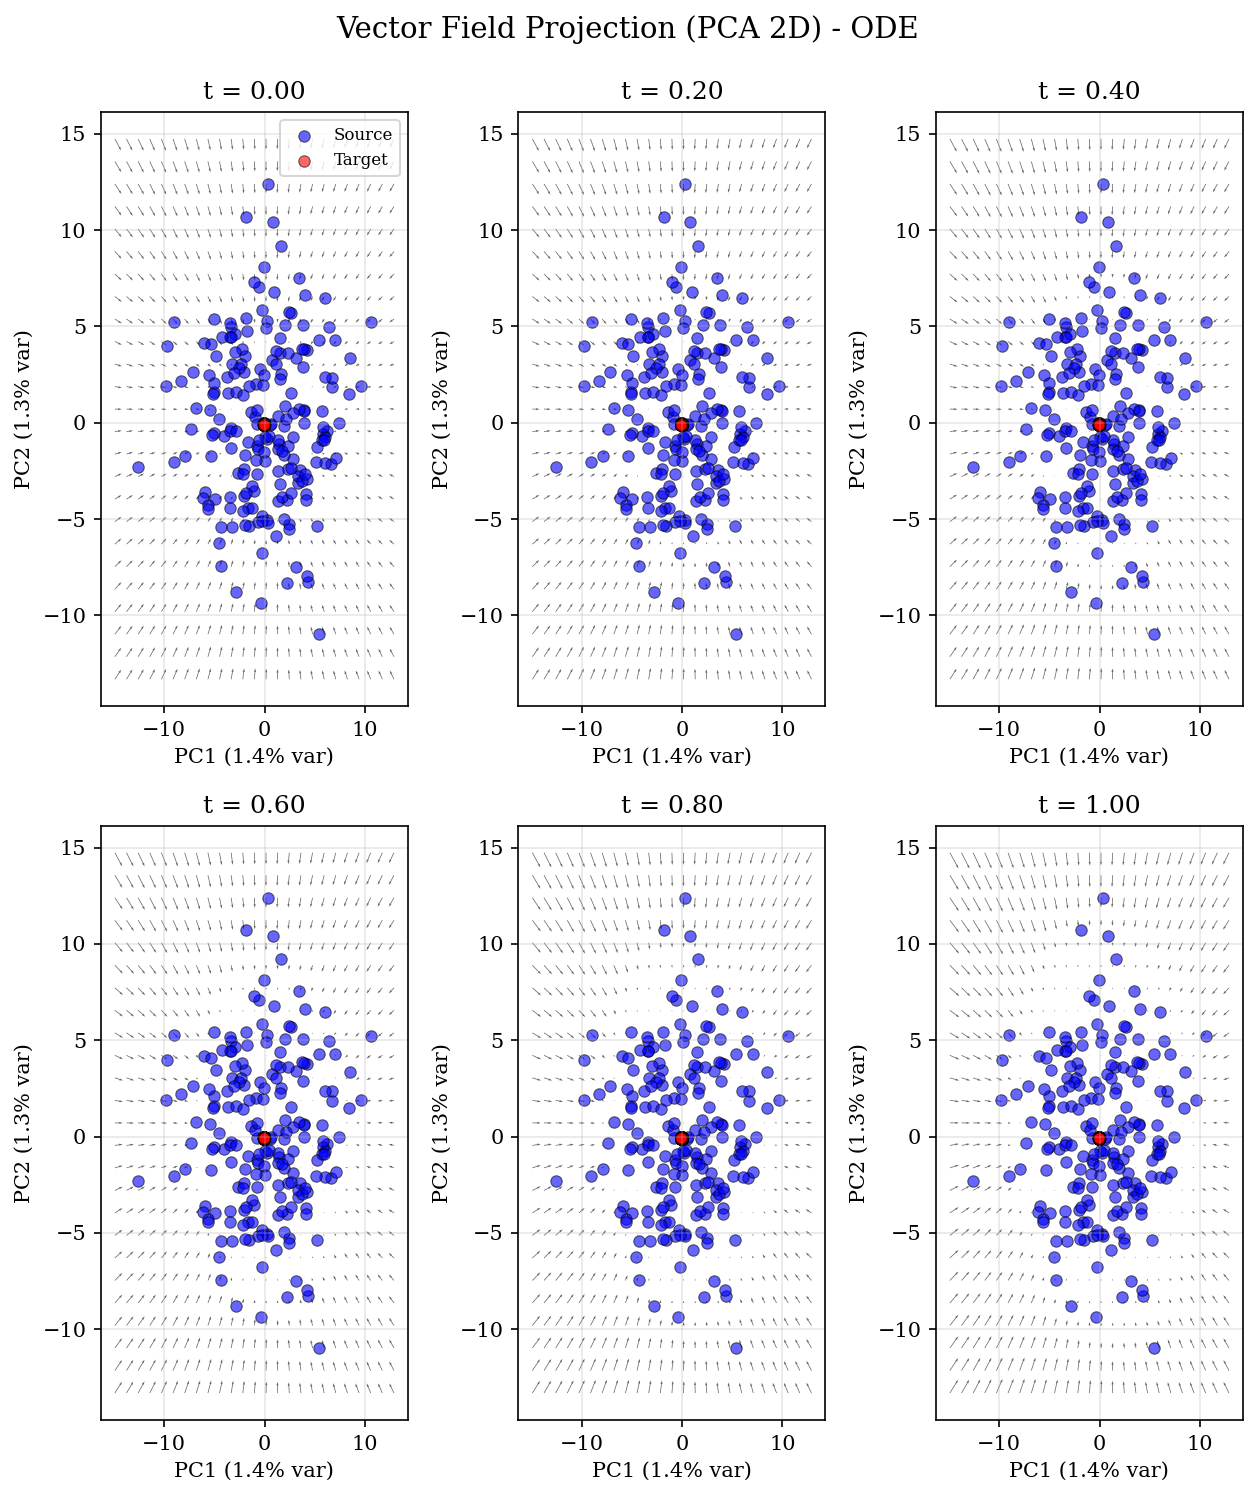

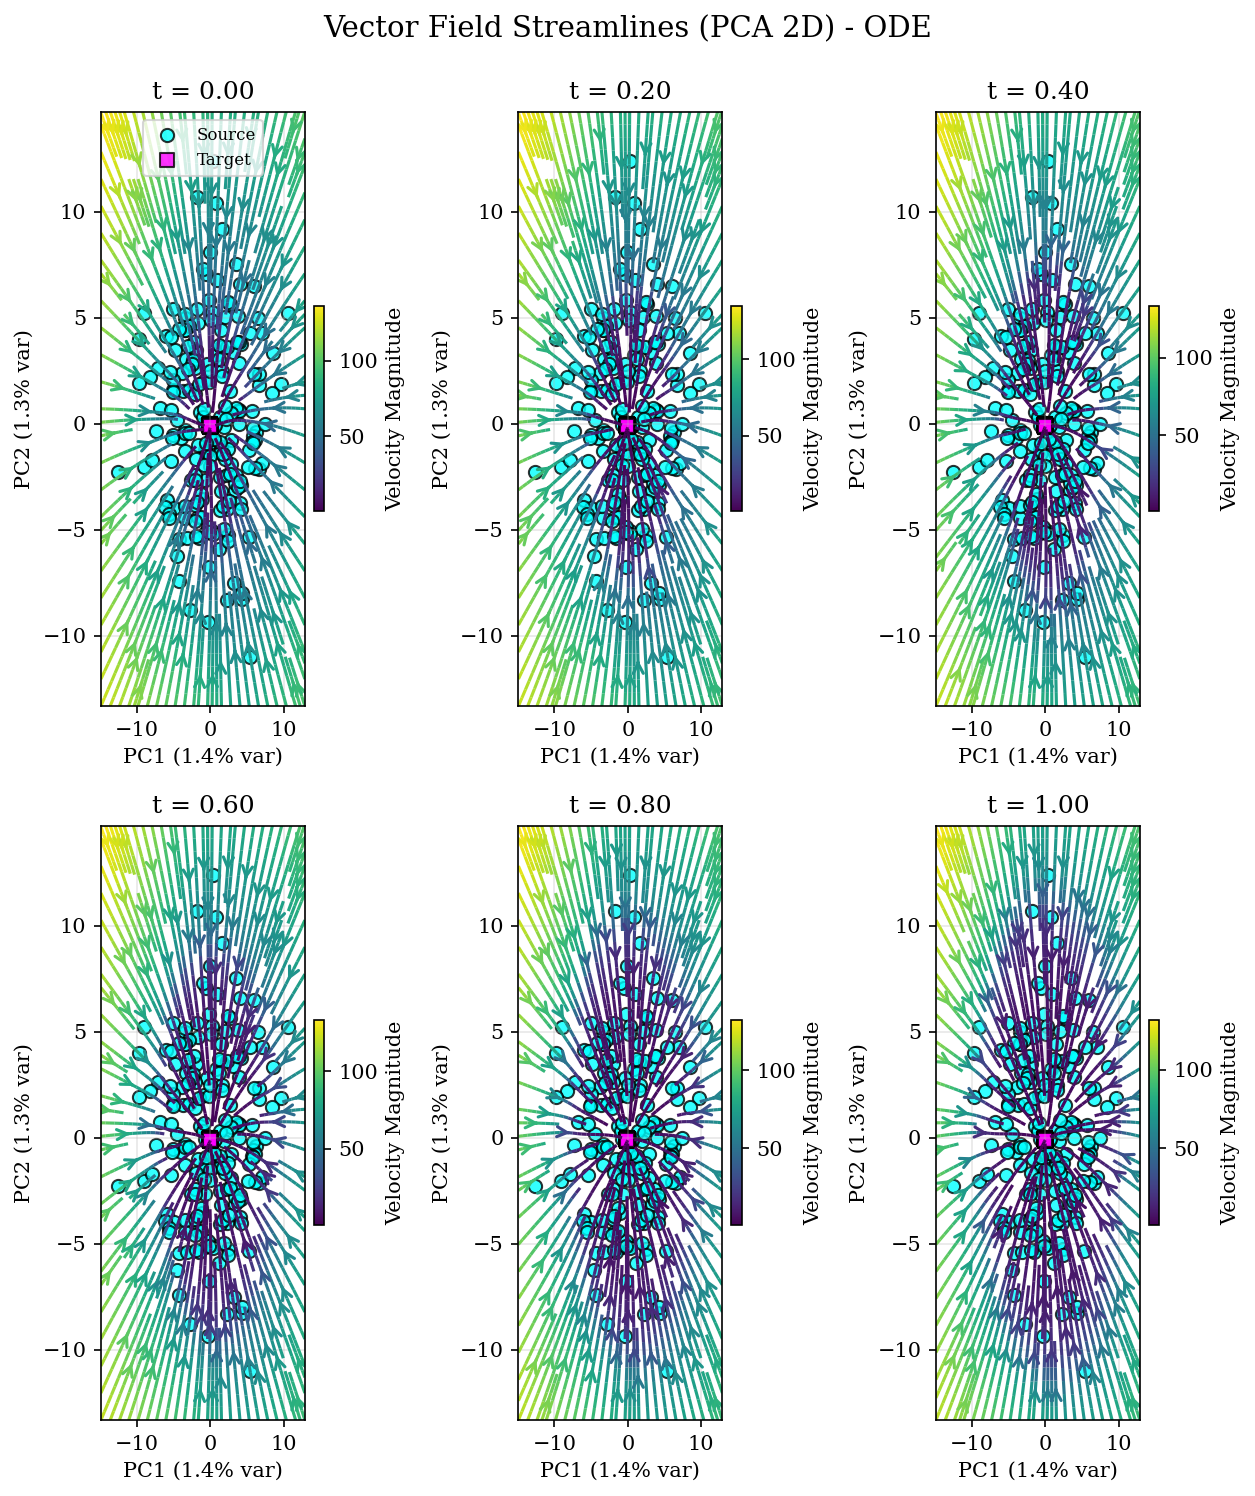

In [7]:
class NotebookRun:
    def log(self, data):
        return None

vector_run = NotebookRun()
vector_outdir = str(ARTIFACT_DIR)

n_vector_times = min(6, run_ctx.t_infer)
if run_ctx.t_infer > 1:
    time_indices = np.linspace(0, run_ctx.t_infer - 1, n_vector_times).astype(int)
    time_points = [float(idx) / (run_ctx.t_infer - 1) for idx in time_indices]
else:
    time_indices = [0]
    time_points = [0.0]

# Use more samples for better visualization
x0_subset = x0_norm[: min(500, x0_norm.shape[0])]
xT_subset = xT_norm[: min(500, xT_norm.shape[0])]

print("Vector field diagnostics in normalized coefficient space")
print(f"Using {x0_subset.shape[0]} samples from source and {xT_subset.shape[0]} samples from target")
print(f"time points: {[f'{t:.2f}' for t in time_points]}")

plot_vector_field_2d_projection(
    flow_wrapper,
    x0_subset,
    xT_subset,
    time_points,
    (run_ctx.coeff_dim,),
    vector_outdir,
    vector_run,
    n_grid=25,
    score=False,
)
plot_vector_field_streamplot(
    flow_wrapper,
    x0_subset,
    xT_subset,
    time_points,
    (run_ctx.coeff_dim,),
    vector_outdir,
    vector_run,
    n_grid=40,
    score=False,
)

show_artifact("vector_field_projection_ode.png")

show_artifact("vector_field_streamplot_ode.png")

## Triplet Interpolation Diagnostics


Creating triplet interpolation visualization with many samples...
Available samples per marginal: 200


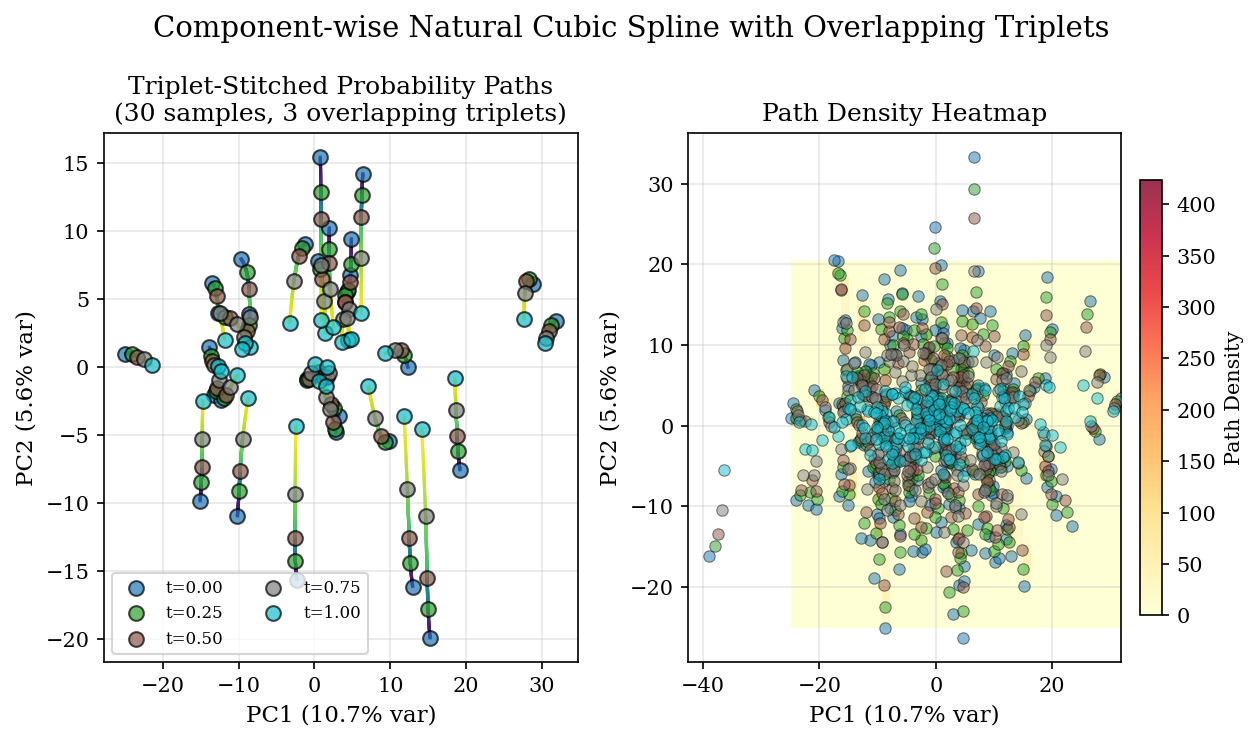

In [8]:
triplet_run = NotebookRun()
triplet_prefix = ARTIFACT_DIR / f"interpolated_paths_triplet_{config.get('spline', 'pchip')}"

# Visualize with many more samples for better density estimation
print(f"Creating triplet interpolation visualization with many samples...")
print(f"Available samples per marginal: {progression_coeffs[0].shape[0]}")

plot_interpolated_probability_paths(
    progression_coeffs,
    zt_values,
    n_samples=min(30, run_ctx.n_infer),  # Increased from 10 to 30
    n_eval_points=100,  # Increased from 50 to 100 for smoother paths
    spline_type=config.get('spline', 'pchip'),
    outdir=str(ARTIFACT_DIR),
    run=triplet_run,
)
show_artifact(triplet_prefix.name + ".png")

## Enhanced Trajectory Visualization with Overlays

Let's visualize many more ODE trajectories overlaid together to see the overall flow pattern.

Creating overlay visualization with 50 ODE trajectories...


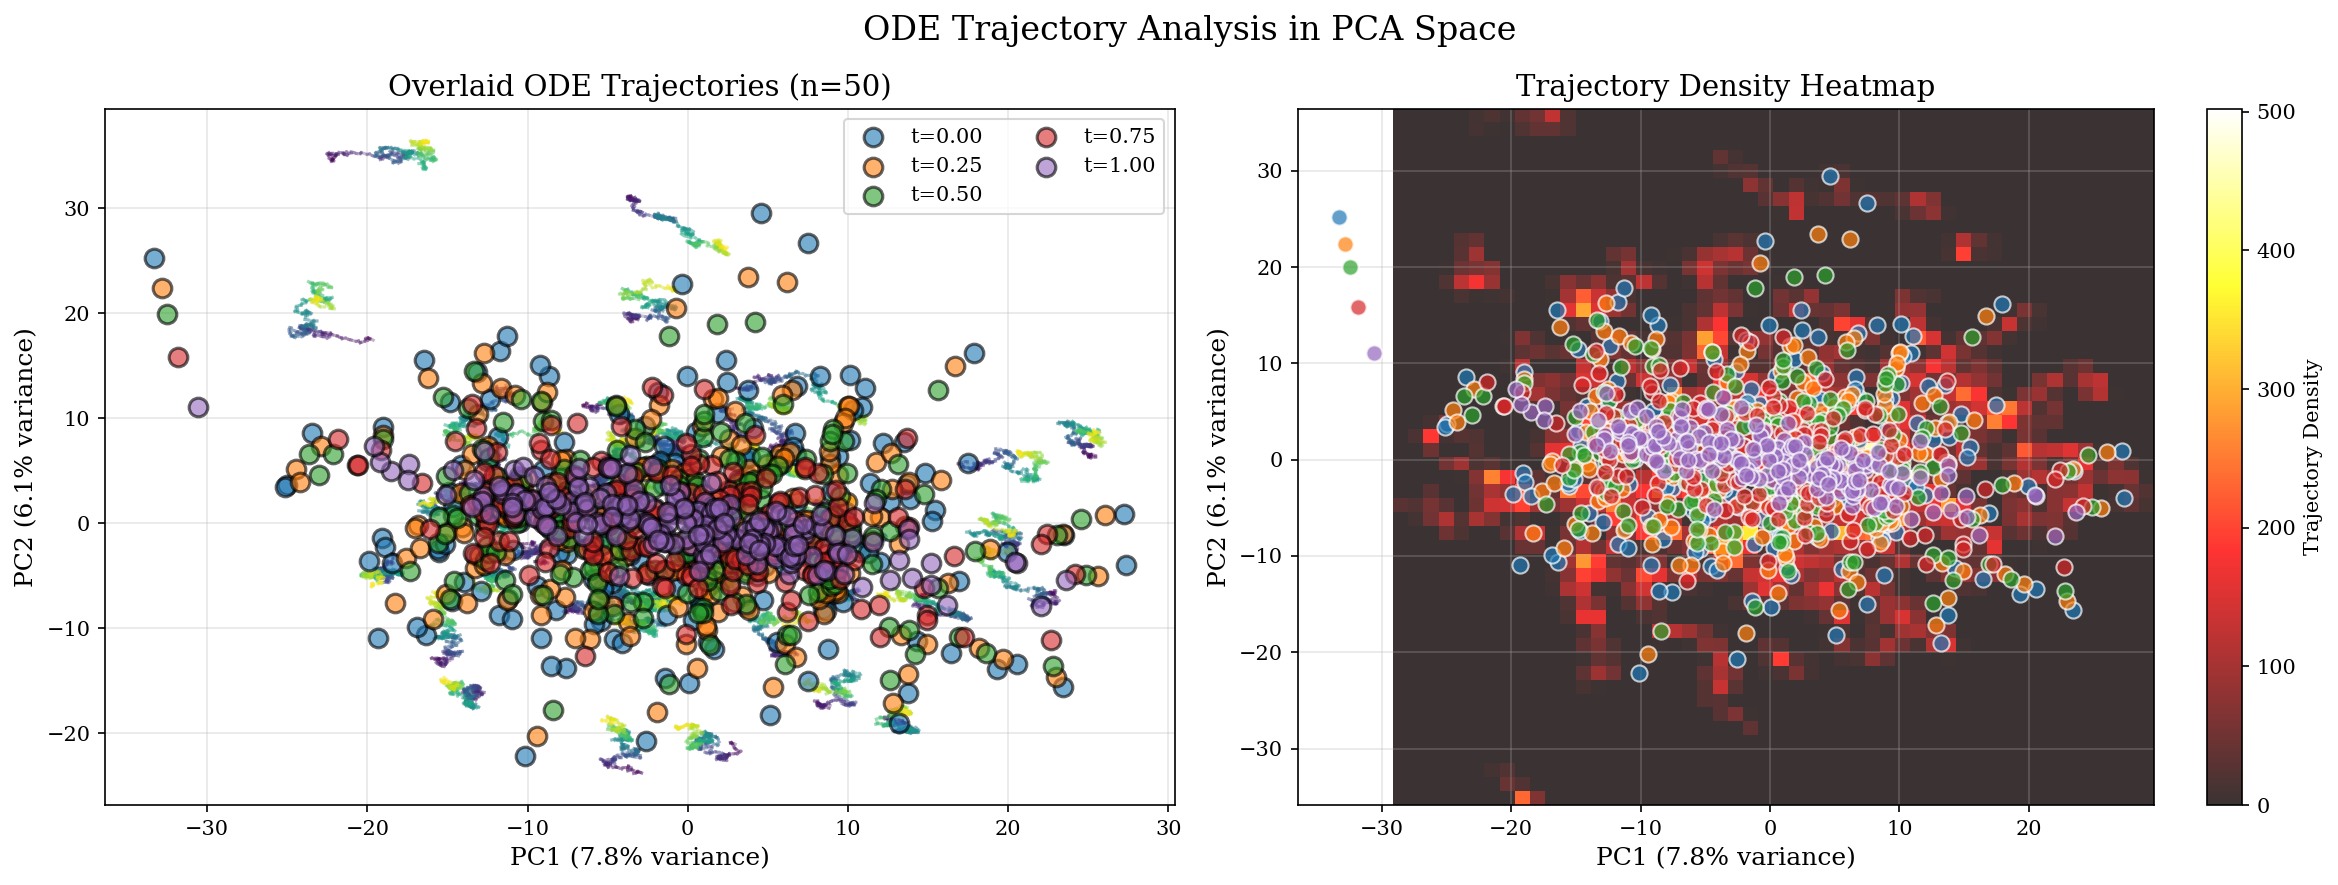

Saved overlay visualization to trajectory_overlay_epoch10.png


In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Create overlaid trajectory visualization with many samples
n_traj_samples = min(50, torch_ode.shape[1])  # Use up to 50 trajectories
time_steps = torch_ode.shape[0]

print(f"Creating overlay visualization with {n_traj_samples} ODE trajectories...")

# Flatten trajectory data for PCA
ode_traj_flat = torch_ode.view(time_steps, torch_ode.shape[1], -1)
all_points = ode_traj_flat.reshape(-1, ode_traj_flat.shape[-1]).numpy()

# Fit PCA to all trajectory points
pca = PCA(n_components=2)
pca.fit(all_points)

# Project trajectories to 2D
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: All trajectories overlaid with color by time
ax = axes[0]
for sample_idx in range(n_traj_samples):
    traj_sample = ode_traj_flat[:, sample_idx, :].numpy()
    traj_proj = pca.transform(traj_sample)
    
    # Color by time progression
    colors = plt.cm.viridis(np.linspace(0, 1, time_steps))
    for t in range(time_steps - 1):
        ax.plot(
            traj_proj[t:t+2, 0], 
            traj_proj[t:t+2, 1], 
            c=colors[t], 
            alpha=0.3, 
            linewidth=1.5
        )

# Overlay marginals
for idx, (coeff, t_val) in enumerate(zip(progression_coeffs, zt_values)):
    coeff_flat = coeff.view(coeff.shape[0], -1).numpy()
    coeff_proj = pca.transform(coeff_flat)
    color = plt.cm.tab10(idx % 10)
    ax.scatter(
        coeff_proj[:, 0], 
        coeff_proj[:, 1], 
        c=[color], 
        s=80, 
        alpha=0.6, 
        label=f't={t_val:.2f}',
        edgecolors='black',
        linewidths=1.5,
        zorder=5
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title(f'Overlaid ODE Trajectories (n={n_traj_samples})', fontsize=14)
ax.legend(loc='best', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)

# Right plot: Trajectory density heatmap
ax = axes[1]
hist, xedges, yedges = np.histogram2d(all_points[:, 0], all_points[:, 1], bins=50)
hist_2d = np.histogram2d(
    pca.transform(all_points)[:, 0],
    pca.transform(all_points)[:, 1],
    bins=50
)[0]

im = ax.imshow(
    hist_2d.T,
    extent=[pca.transform(all_points)[:, 0].min(), pca.transform(all_points)[:, 0].max(),
            pca.transform(all_points)[:, 1].min(), pca.transform(all_points)[:, 1].max()],
    origin='lower',
    cmap='hot',
    aspect='auto',
    alpha=0.8
)
plt.colorbar(im, ax=ax, label='Trajectory Density')

# Overlay marginals on heatmap
for idx, (coeff, t_val) in enumerate(zip(progression_coeffs, zt_values)):
    coeff_flat = coeff.view(coeff.shape[0], -1).numpy()
    coeff_proj = pca.transform(coeff_flat)
    color = plt.cm.tab10(idx % 10)
    ax.scatter(
        coeff_proj[:, 0], 
        coeff_proj[:, 1], 
        c=[color], 
        s=60, 
        alpha=0.7,
        edgecolors='white',
        linewidths=1,
        zorder=5
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('Trajectory Density Heatmap', fontsize=14)
ax.grid(True, alpha=0.3)

fig.suptitle('ODE Trajectory Analysis in PCA Space', fontsize=16)
fig.tight_layout()

# Save
overlay_path = ARTIFACT_DIR / f"trajectory_overlay_epoch{target_epoch}.png"
fig.savefig(overlay_path, dpi=150, bbox_inches='tight')
plt.close(fig)

display(Image(filename=str(overlay_path)))
print(f"Saved overlay visualization to {overlay_path.name}")

## Training Curves


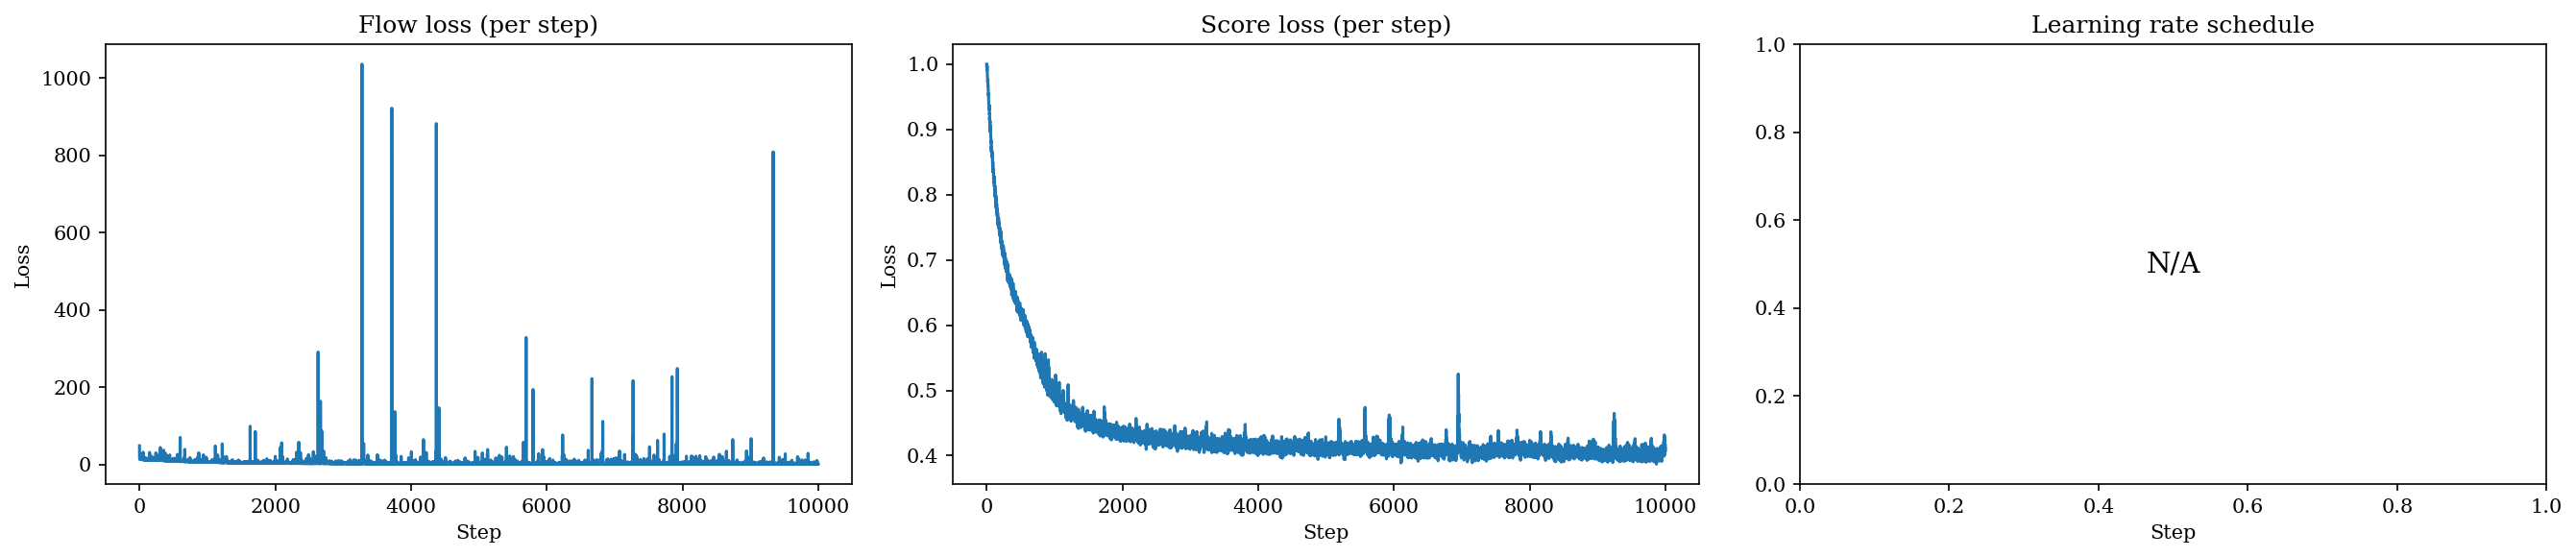

In [10]:
import matplotlib.pyplot as plt

flow_loss_path = RESULT_DIR / "flow_losses.npy"
score_loss_path = RESULT_DIR / "score_losses.npy"
lrs_path = RESULT_DIR / "lrs.npy"

if not flow_loss_path.exists():
    print("Flow loss history not found; skipping curve plots.")
else:
    flow_losses = np.load(flow_loss_path)
    if flow_losses.ndim == 1:
        flow_losses = flow_losses[None, :]
    score_losses = np.load(score_loss_path) if score_loss_path.exists() else None
    if score_losses is not None and score_losses.ndim == 1:
        score_losses = score_losses[None, :]
    lrs = np.load(lrs_path) if lrs_path.exists() else None

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    axes[0].set_title("Flow loss (per step)")
    axes[0].plot(np.concatenate(flow_losses))
    axes[0].set_xlabel("Step")
    axes[0].set_ylabel("Loss")

    axes[1].set_title("Score loss (per step)")
    if score_losses is not None:
        axes[1].plot(np.concatenate(score_losses))
    else:
        axes[1].text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=14)
    axes[1].set_xlabel("Step")
    axes[1].set_ylabel("Loss")

    axes[2].set_title("Learning rate schedule")
    if lrs is not None:
        axes[2].plot(np.concatenate(lrs))
    else:
        axes[2].text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=14)
    axes[2].set_xlabel("Step")

    fig.tight_layout()
    curves_path = ARTIFACT_DIR / "training_curves.png"
    fig.savefig(curves_path, dpi=150, bbox_inches="tight")
    plt.close(fig)
    display(Image(filename=str(curves_path)))


## Next Steps

Inspect the generated files in `notebook_artifacts/` to compare runs, assemble figures, or launch further quantitative analyses.
